# A (slightly) Advanced Tutorial

In the following tutorial, we will calculate **leading-order (LO)**
cross section of the production of a same-flavour opposite-sign (SFOS) 
lepton-pair (also known as Drell-Yan lepton-pair production) at the 
LHC: $\mathrm{p}\mathrm{p} \to \ell\bar{\ell}$ @ 7 TeV. In particular,
we are going to look at the differential distribution in the rapidity
of the lepton pair, in the setup given by <https://arxiv.org/abs/1310.7291>.

That is, we'll write a Monte Carlo integrator that calculates a part of 
this process and produces an interpolation grid. The following steps will
provide a tangible illustration on how to fill a PineAPPL grid with the
various ingredients. These steps involve the computation of the matrix
element and the generation of the phase space.

## Computing an observable

A physical observable that involves two hadrons in the initial states is computed as:
$$ \left\langle \frac{\sigma^{hh \to F}}{\mathrm{d} \mathcal{O}} \right\rangle = \sum_{a,b} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^h (x_1) f_b^h (x_2) \frac{\sigma_{ab \to F} (x_1, x_2)}{\mathrm{d} \mathcal{O}} $$
where the partonic cross section is a perturbative series in the two couplings (strong coupling: $\alpha_s (M_\mathrm{Z}^2) = 0.118$ and electromagnetic coupling $\alpha(0) \approx 1/137 \approx 0.0073$):
$$ \frac{\sigma_{ab} (x_1, x_2)}{\mathrm{d} \mathcal{O}} = \sum_{n,m} \alpha_\mathrm{s}^n \alpha^m \frac{\sigma_{ab}^{n,m} (x_1, x_2)}{\mathrm{d} \mathcal{O}} $$
Since $\alpha_s \gg \alpha$ we usually look only at the lowest order $m$ and calculate corrections in $n$: this is what we refer as QCD corrections. However, this isn't always reliable, sometimes electroweak (EW) corrections are needed.

Inserting the perturbative expansion into the main formula:
$$ \left\langle \frac{\sigma^{hh \to F}}{\mathrm{d} \mathcal{O}} \right\rangle = \sum_{a,b} \sum_{n,m} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^h (x_1) f_b^h (x_2) \alpha_\mathrm{s}^n \alpha^m \frac{\sigma_{ab \to F}^{n,m} (x_1, x_2)}{\mathrm{d} \mathcal{O}} $$

We can construct $\sigma_{ab \to F}^{n,m} (x_1, x_2) / \mathrm{d} \mathcal{O}$ and call that **interpolation grid**. They have the advantage that one can very quickly (less than a second) perform the integrals above with any PDF set, very important especially for PDF sets.

## Compute matrix elements

The first step in computing theory predictions is the computation of the matrix elements (amplitudes). The next step is to sum all the amplitudes and take the modulus squared. It is common practice to also account for the flux factor and the spin and color sums together with their eventual average. Recall to average on the input and to sum on the output. In our example we find:
$$ \frac {1}{2 s} |\mathcal M_t + \mathcal M_u |^2 = \frac{\alpha^2}{2s} \left(\frac t u + \frac u t\right) $$

In [1]:
def photon_photon_matrix_element(s: float, t: float, u: float) -> float:
    alpha0 = 1.0 / 137.03599911
    return alpha0 * alpha0 / 2.0 / s * (t / u + u / t)

## Determine phase space decomposition

Given the initial states with momenta $k_1$ and $k_2$ we need to integrate the squared matrix elements over all possible momenta, that is all momenta which fulfill momentum conservation and which are on-shell: $ p_i^2 = m_i^2 $. In general this integral (Lorentz invariant phase-space (LIPS)) is:

$$ \int \mathrm{d} \mathrm{LIPS} = \int \left( \prod_{i=1}^n \mathrm{d}^4 p_i \right) \, \delta^{(4)} \left( k_1 + k_2 - \sum_{i=1}^n p_i \right) \prod_{i = 1}^n \delta \left( p_i^2 - m_i^2 \right) $$

and has $4n$ integration dimensions, reduced to $3n - 4$ through the momentum conservation ($-4$) and on-shell conditions ($-n$).

In our example we have two massless final state particles ($n = 2$ and $m_1 = m_2 = 0$), so effectively we integrate over $3n - 4 = 2$ dimensions. We choose to integrate over these two variables:
1. $\cos \theta$, where $\theta$ measures the angle of one of the leptons w.r.t. the beam axis and
2. the angle $\phi$, which is another angle transverse to the beam axis.

Matrix elements do not depend on the angle $\phi$, since the collision is symmetric around the beam axis.

## Compute phase space integrals

Our master formula,

$$ \sigma^{\mathrm{p}\mathrm{p} \to \ell\bar{\ell}} = \sum_{a,b} \int \mathrm{d} x_1 \mathrm{d} x_2 f_a^\mathrm{p} (x_1) f_b^\mathrm{p} (x_2) \sigma_{ab \to \ell\bar{\ell}} (x_1, x_2) $$

requires us to integrate over all possible momentum fractions $x_1$ and $x_2$ of the two PDFs. We do this by rewriting the integral into $\tau$, relative centre-of-mass energy squared and $y$, the rapidity relating the hadronic and partonic centre-of-mass frames:

$$ \int_0^1 \mathrm{d} x_1 \int_0^1 \mathrm{d} x_2 = \int \mathrm{d} \tau \int \mathrm{d} y $$

The exact form of this transformation isn't really important, but it is chosen such that the jacobian contains the inverse flux factor, cancelling the flux factor multiplied to the squared matrix elements above.

We approximate the integrals numerically by using a Monte Carlo integration, which computes the average of the integrand evaluated using uniformly chosen random numbers $r_1, r_2, r_3$:

$$ \int_0^1 \mathrm{d} r_1 \int_0^1 \mathrm{d} r_2 \int_0^1 \mathrm{d} r_3 f(r_1, r_2, r_3) \approx \frac{1}{N} \sum_{i=1}^N f(r_1^i, r_2^i, r_3^i) $$

Translated to Python code this reads:

In [2]:
import math
import numpy as np
from typing import Tuple

def hadronic_ps_gen(
    mmin: float, mmax: float
) -> Tuple[float, float, float, float, float, float]:
    r"""Hadronic phase space generator.

    Parameters
    ----------
    mmin :
        minimal partonic centre-of-mass energy :math:`\sqrt{s_{min}}`
    mmax :
        maximal partonic centre-of-mass energy :math:`\sqrt{s_{max}}`

    Returns
    -------
    s :
        Mandelstam s
    t :
        Mandelstam t
    u :
        Mandelstam u
    x1 :
        first momentum fraction
    x2 :
        second momentum fraction
    jacobian :
        jacobian from the uniform generation

    """
    smin = mmin * mmin
    smax = mmax * mmax

    r1 = np.random.uniform()
    r2 = np.random.uniform()
    r3 = np.random.uniform()
    
    # generate partonic x1 and x2
    tau0 = smin / smax
    tau = pow(tau0, r1)
    y = pow(tau, 1.0 - r2)
    x1 = y
    x2 = tau / y
    s = tau * smax

    jacobian = tau * np.log(tau0) * np.log(tau0) * r1

    # theta integration (in the CMS)
    cos_theta = 2.0 * r3 - 1.0
    jacobian *= 2.0

    # reconstruct invariants (in the CMS)
    t = -0.5 * s * (1.0 - cos_theta)
    u = -0.5 * s * (1.0 + cos_theta)

    # phi integration
    jacobian *= 2.0 * math.acos(-1.0)

    return [s, t, u, x1, x2, jacobian]

Now we can test the integration by generating a phase-space point between $s_\text{min} = (10~\text{GeV})^2$ and $s_\text{max} = (7000~\text{GeV})^2$ (our hadronic centre-of-mass energy):

In [3]:
[s, t, u, x1, x2, jacobian] = hadronic_ps_gen(10.0, 7000.0)

# print(
#     "s = {:.6e}\nt = {:.6e}\nu = {:.6e}\n\nx1 = {:.6e}\nx2 = {:.6e}\n\ns + t + u = {:.6e}"
#     .format(s, t, u, x1, x2, s + t + u)
# )
print("Values of the Mandelstam variables:")
print(f"s = {s:.6e}\nt = {t:.6e}\nu = {u:.6e}")

print("\nValues of the partonic variables x1 and x2:")
print(f"x1 = {x1:.6e}\nx2 = {x2:.6e}")

print("\nCheck the sum of the Mandelstam variables:")
print(f"s+t+u = {s+t+u:.6e}")

Values of the Mandelstam variables:
s = 2.825533e+04
t = -1.037558e+04
u = -1.787975e+04

Values of the partonic variables x1 and x2:
x1 = 2.872756e-03
x2 = 2.007269e-01

Check the sum of the Mandelstam variables:
s+t+u = 0.000000e+00


## Join phase space integration and matrix elements

Finally, we have to
- put the integral together with the squared matrix elements,
- transform the phase-space variables into the well-known LAB quantities, and
- we want to simulate the setup from CMS DY 7 TeV, see: <https://arxiv.org/abs/1310.7291>

This means, we
- add phase-space cuts:
  - $ p_\mathrm{T}^\ell > 14~\text{GeV} $
  - $ |y^\ell| < 2.4 $
  - $ 60~\text{GeV} < M_{\ell\bar{\ell}} < 120~\text{GeV} $
- and we want the differential cross section w.r.t. $|y_{\ell\bar{\ell}}|$, with bin limits $0 < |y_{\ell\bar{\ell}}| < 2.4$, in steps of $0.1$.

In [4]:
import pineappl

def fill_grid(grid: pineappl.grid.Grid, calls: int):
    """Fill grid with points."""

    # in GeV^2 pbarn
    hbarc2 = 389379372.1

    # perform Monte Carlo sum
    for _ in range(calls):
        # compute phase space
        s, t, u, x1, x2, jacobian = hadronic_ps_gen(10.0, 7000.0)

        # build observables
        ptl = np.sqrt((t * u / s))
        mll = np.sqrt(s)
        yll = 0.5 * np.log(x1 / x2)
        ylp = np.abs(yll + math.acosh(0.5 * mll / ptl))
        ylm = np.abs(yll - math.acosh(0.5 * mll / ptl))

        # apply conversion factor
        jacobian *= hbarc2 / calls

        # cuts for LO for the invariant-mass slice containing the Z-peak from CMS (7 TeV): https://arxiv.org/abs/1310.7291
        if (
            ptl < 14.0
            or np.abs(yll) > 2.4
            or ylp > 2.4
            or ylm > 2.4
            or mll < 60.0
            or mll > 120.0
        ):
            # continuing means this we don't call fill below that means this event counts as zero or it 'cut away'
            continue

        # build event
        weight = jacobian * photon_photon_matrix_element(s, u, t)
        # set factorization and renormalization scale to (roughly) the Z-boson mass
        q2 = 90.0 * 90.0
    
        # fill the interpolation grid
        grid.fill(x1, x2, q2, 0, np.abs(yll), 0, weight)

We want our results stored in an interpolation grid, which is independent of PDFs and the strong coupling. To create a `Grid`, we need to give it a few bits of information. We have to tell it that

- our initial state is photon-photon, or in PDG Monte Carlo IDs `(22, 22)`
- the perturbative order in $\alpha^2$
- as per CMS's setup we bin the observable from $0$ to $2.4$ in steps of $0.1$.

In [5]:
def generate_grid(calls: int) -> pineappl.grid.Grid:
    """Generate the grid."""
    # create a new luminosity function for the $\gamma\gamma$ initial state
    lumi_entries = [pineappl.boc.Channel([(22, 22, 1.0)])]
    # only LO $\alpha_\mathrm{s}^0 \alpha^2 \log^0(\xi_\mathrm{R}) \log^0(\xi_\mathrm{F})$
    orders = [pineappl.grid.Order(0, 2, 0, 0)]
    bins = np.arange(0, 2.4, 0.1)
    params = pineappl.subgrid.SubgridParams()
    grid = pineappl.grid.Grid(lumi_entries, orders, bins, params)

    # fill the grid with phase-space points
    print(f"Generating {calls} events, please wait...")
    fill_grid(grid, calls)
    print("Done.")

    return grid

We have play a bit with the Monte Carlo statistics, to produce smooth results. To generate a full theory predictions, we must also use our master formula and convolute the interpolation grid with the two photon PDFs. Finally, let's plot the result:

In [6]:
import lhapdf

# generate interpolation grid: increase this number!
grid = generate_grid(1000000)

# perform convolution with PDFs: this performs the x1 and x2 integrals
# of the partonic cross sections with the PDFs as given by our master 
# formula
pdf = lhapdf.mkPDF("NNPDF31_nnlo_as_0118_luxqed", 0)
bins = grid.convolve_with_one(2212, pdf.xfxQ2, pdf.alphasQ2)

Generating 1000000 events, please wait...
Done.
LHAPDF 6.5.4 loading /home/tanjona/miniconda3/envs/nnpdf/share/LHAPDF/NNPDF31_nnlo_as_0118_luxqed/NNPDF31_nnlo_as_0118_luxqed_0000.dat
NNPDF31_nnlo_as_0118_luxqed PDF set, member #0, version 2; LHAPDF ID = 325100


**NOTE:** If you do not have `NNPDF31_nnlo_as_0118_luxqed` installed, you can do so with the following command:

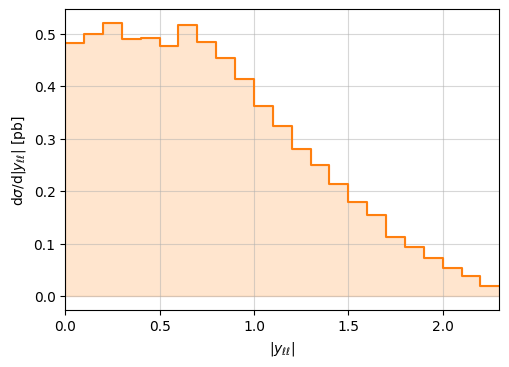

In [7]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5.6, 3.9))

# matplotlib's 'step' function requires the last value to be repeated
nbins = np.append(bins, bins[-1])
edges = np.arange(0.0, 2.4, 0.1)

ax.step(edges, nbins, where='post', color="C1")
plt.fill_between(np.arange(0.0, 2.4, 0.1), nbins, step="post", color="C1", alpha=0.2)
ax.set_xlabel("$|y_{\ell\ell}|$")
ax.set_ylabel("$\mathrm{d} \sigma / \mathrm{d} |y_{\ell\ell}|$ [pb]")
ax.grid(True, alpha=0.5)
ax.set_xlim([edges[0], edges[-1]])

plt.show()